In [20]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

import yfinance as yf
from talib import abstract

from backtesting import Strategy, Backtest
from backtesting.lib import crossover

# SK-learn libraries for data processing and learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

## Get example data from Generated CSV File

In [2]:
# Get signal data written to csv to start
df = pd.read_csv("example_data.csv")
print(df.columns)
df.shape

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'Return', 'Return%', 'L5D_Return', 'L5D_Return%',
       'N5D_Return', 'N5D_Return%', 'N5D_Return_Delayed',
       'N5D_Return_Delayed%', '52Wk_High', '52Wk_Low', '%52Wk_High',
       '%52Wk_Low', 'Open%PriorClose', 'Close%Open', 'Close%High', 'Close%Low',
       'Div%Close', '52Wk_Avg_Volume', '%52Wk_Avg_Volume', 'SMA3', 'SMA5',
       'SMA10', 'SMA15', 'SMA20', 'SMA30', 'SMA50', 'SMA3%', 'SMA5%', 'SMA10%',
       'SMA15%', 'SMA20%', 'SMA30%', 'SMA50%', 'EMA3', 'EMA5', 'EMA10',
       'EMA15', 'EMA20', 'EMA30', 'EMA50', 'EMA3%', 'EMA5%', 'EMA10%',
       'EMA15%', 'EMA20%', 'EMA30%', 'EMA50%', 'PP', 'S1C', 'S2C', 'S3C',
       'R1C', 'R2C', 'R3C', 'PP%', 'S1C%', 'S2C%', 'S3C%', 'R1C%', 'R2C%',
       'R3C%', 'S1F', 'S2F', 'S3F', 'R1F', 'R2F', 'R3F', 'S1F%', 'S2F%',
       'S3F%', 'R1F%', 'R2F%', 'R3F%', 'SMA_Signal', 'MACD_Signal', 'RSI',
       'RSI_Signal', 'Slow_K', 'Slow_D', 'Stoch_Osci', 

(3771, 92)

In [3]:
# Adjusting Buy and Sell labels based on return, using the following metrics and thresholds
return_metric = df["N5D_Return_Delayed%"]
buy_threshold = 0.005
sell_threshold = -0.005

buy_signal = pd.Series(return_metric >= buy_threshold).astype(int)
sell_signal = pd.Series(return_metric <= sell_threshold).astype(int) * -1
labels = buy_signal + sell_signal
df["Labels"] = labels.values

# Drop NA rows where metrics cannot be computed (beginning and end of the dataframe)
# Drops about a year plus a few days of data
df.dropna(axis=0, how='any', inplace=True)

In [4]:
# Get labels and features data
N5D = df["N5D_Return_Delayed%"]
labels = df["Labels"]

# Only use standardized features  
data = df[['Stock Splits', 'Return%', 'L5D_Return%', \
           '%52Wk_High','%52Wk_Low', 'Open%PriorClose', \
           'Close%Open', 'Close%High', 'Close%Low','Div%Close', \
           'SMA3%', 'SMA5%', 'SMA10%', 'SMA15%', 'SMA20%', 'SMA30%', 'SMA50%', \
           'EMA3%', 'EMA5%', 'EMA10%', 'EMA15%', 'EMA20%', 'EMA30%', 'EMA50%', \
           'PP%', 'S1C%', 'S2C%','S3C%', 'R1C%', 'R2C%', 'R3C%', \
           'S1F%', 'S2F%', 'S3F%', 'R1F%', 'R2F%', 'R3F%', \
           'SMA_Signal', 'MACD_Signal', 'RSI', 'RSI_Signal', 'Slow_K', 'Slow_D', \
           'Stoch_Osci', 'Fast_K', 'Fast_D', 'Stoch_RSI']]

data.shape

(3771, 47)

(array([  1.,   0.,   1.,   0.,   4.,   0.,   1.,   1.,   1.,   2.,   4.,
          6.,   8.,  12.,  18.,  23.,  59.,  70., 151., 220., 384., 694.,
        866., 649., 295., 139.,  77.,  30.,  18.,  18.,   3.,   3.,   1.,
          2.,   6.,   2.,   0.,   0.,   1.,   1.]),
 array([-8.21363697, -7.841296  , -7.46895504, -7.09661407, -6.7242731 ,
        -6.35193214, -5.97959117, -5.6072502 , -5.23490924, -4.86256827,
        -4.4902273 , -4.11788634, -3.74554537, -3.3732044 , -3.00086344,
        -2.62852247, -2.2561815 , -1.88384054, -1.51149957, -1.1391586 ,
        -0.76681764, -0.39447667, -0.0221357 ,  0.35020526,  0.72254623,
         1.0948872 ,  1.46722816,  1.83956913,  2.2119101 ,  2.58425106,
         2.95659203,  3.328933  ,  3.70127396,  4.07361493,  4.4459559 ,
         4.81829686,  5.19063783,  5.5629788 ,  5.93531976,  6.30766073,
         6.6800017 ]),
 <BarContainer object of 40 artists>)

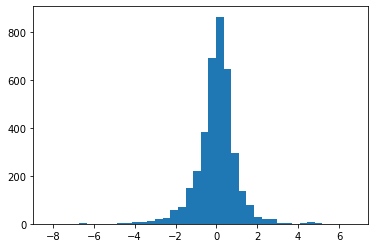

In [5]:
norm_N5D=(N5D-N5D.mean())/N5D.std()
plt.hist(norm_N5D, bins=40)

In [6]:
# Splitting training data to train and dev data
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, shuffle=False)

## Take a look at the data sets
print("train_data:", train_data.shape)
print("train_labels:", train_labels.shape)
print("test_data:", test_data.shape)
print("test_labels:", test_labels.shape)

train_data: (3016, 47)
train_labels: (3016,)
test_data: (755, 47)
test_labels: (755,)


(array([220.,   0.,   0.,   0.,   0., 143.,   0.,   0.,   0., 392.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

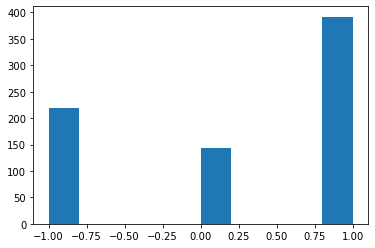

In [7]:
plt.hist(test_labels)

## Logistic Regression Model

In [8]:
## Logistic Regression model, feature select using L2 regularization
print("Logistic Regression Model:\n")
print("{:>8}  {:>10}{:>10}".format("L2 c", "accuracy", "f1"))
print("-" * 30)

# Produce Logistic Regression models with various C values
c_values = [0.1, 1, 10, 100, 500, 1000, 2500, 5000, 7000, 8000, 9000, 10000, 20000]
best_c, best_f1 = 0, 0

for c in c_values:
    lr_model = LogisticRegression(C=c, solver="liblinear")
    lr_model.fit(train_data, train_labels)
    accuracy = lr_model.score(test_data, test_labels)
    f1 = metrics.f1_score(test_labels, lr_model.predict(test_data), average='weighted')
    print("{:>8}  {:10.4f}{:10.4f}".format(c, accuracy, f1))
    if f1 > best_f1:
        best_c = c
        best_f1 = f1 

print("\nBest f1 score of {:.4f} at C={}".format(best_f1, best_c))

Logistic Regression Model:

    L2 c    accuracy        f1
------------------------------
     0.1      0.5113    0.3615
       1      0.5166    0.3767
      10      0.5139    0.4006
     100      0.5152    0.4055
     500      0.5113    0.4059
    1000      0.5152    0.4075
    2500      0.5139    0.4048
    5000      0.5166    0.4079
    7000      0.5152    0.4069
    8000      0.5192    0.4098
    9000      0.5166    0.4076
   10000      0.5166    0.4077
   20000      0.5152    0.4071

Best f1 score of 0.4098 at C=8000


In [9]:
# Get the best model results
lr_model = LogisticRegression(C=9000, solver="liblinear")
lr_model.fit(train_data, train_labels)

LogisticRegression(C=9000, solver='liblinear')

### Take a look at the classification report

In [10]:
# First look at classification report
pred_labels = lr_model.predict(test_data)
score=lr_model.score(test_data, test_labels)
target_names = ['Sell', 'Hold', 'Buy']

print(classification_report(test_labels, pred_labels, target_names = target_names) )

              precision    recall  f1-score   support

        Sell       0.50      0.04      0.07       220
        Hold       0.35      0.14      0.20       143
         Buy       0.53      0.92      0.67       392

    accuracy                           0.52       755
   macro avg       0.46      0.37      0.31       755
weighted avg       0.49      0.52      0.41       755



(array([ 16.,   0.,   0.,   0.,   0.,  57.,   0.,   0.,   0., 682.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

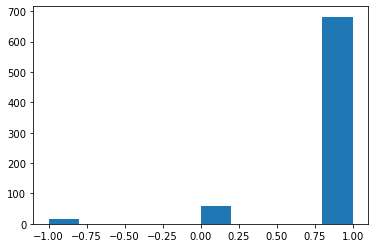

In [11]:
plt.hist(pred_labels)

In [12]:
print(confusion_matrix(test_labels, pred_labels))

[[  8  15 197]
 [  0  20 123]
 [  8  22 362]]


### Examine feature coefficients of best model with L2 regularization

In [13]:
## Get the top features from the model
indices, features, sell_weights, hold_weights, buy_weights = [], [], [], [], []
indices.extend(np.argsort(-lr_model.coef_[2]))

#for i in range(len(train_data.columns)):
for i in indices:
    features.append(train_data.columns[i])
    sell_weights.append(lr_model.coef_[0][i])
    hold_weights.append(lr_model.coef_[1][i])
    buy_weights.append(lr_model.coef_[2][i])
    
## Set up table to print results
print("Features from the Logistic Regression Model with Weights:\n")
print("{:>20}{:>20}{:>20}{:>20}".format("Features", "Sell Weight", "Hold Weight", "Buy Weight"))
print("-" * 80)

## Print the features along with weights
for i in range(int(len(features))):
        print("{:>20}{:20.4f}{:20.4f}{:20.4f}"
              .format(features[i], sell_weights[i], hold_weights[i], buy_weights[i]))

Features from the Logistic Regression Model with Weights:

            Features         Sell Weight         Hold Weight          Buy Weight
--------------------------------------------------------------------------------
              SMA30%              0.1672             -4.4593              5.9876
              SMA10%             -0.0229             -1.1291              4.1645
              SMA15%              0.0315             -0.9905              2.6821
     Open%PriorClose              0.4265             -4.6140              0.8338
              EMA20%              0.5703             -1.7186              0.7688
              EMA15%              0.4534             -1.0121              0.6845
           %52Wk_Low              0.1367             -0.5092              0.3835
              EMA50%              1.1732             -3.2657              0.2723
              EMA30%              0.9313             -2.9289              0.2352
              EMA10%              0.4222          

### Additional feature selection using both L1 and L2 regularization

In [14]:
## Improved Logistic Regression Model: using preprocessed training and dev data
np.random.seed(0) ## keep for comparison purposes

## Print result table headers
print("Logistic Regression Model with L1 and L2 Regularization:\n")
print("{:>15}{:>15}{:>15}{:>15}".format("L1 C value", "feature size", "accuracy", "f1"))
print("-" * 60)

## Produce Logistic Regression models with various C values for L1 regularization
c_values = c_values = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500]
best_c, best_f1 = 0, 0

for c in c_values:
    ## Feature selection model with L1 regularization, test different C strengths
    lrm = LogisticRegression(C=c, solver="liblinear", penalty="l1", tol=0.015)
    lrm.fit(train_data, train_labels)

    ## Get non-zero features
    nz_features = []
    for i in range(len(train_data.columns)):
        if abs(lrm.coef_[0][i]) > 0 or abs(lrm.coef_[2][i]) > 0:
            nz_features.append(train_data.columns[i])
    
    ## New model with L2 regularization
    new_train_data = train_data[nz_features]
    new_test_data = test_data[nz_features]

    lrm = LogisticRegression(C=8000, solver="liblinear", penalty="l2")
    lrm.fit(new_train_data, train_labels)
    accuracy = lrm.score(new_test_data, test_labels)
    f1 = metrics.f1_score(test_labels, lrm.predict(new_test_data), average='weighted')
    print("{:>15}{:>15}{:>15.4f}{:>15.4f}".format(c, len(nz_features), accuracy, f1))
    if f1 > best_f1:
        best_c = c
        best_f1 = f1

print("\nBest f1 score of {:.4f} at L1 C={}".format(best_f1, best_c))

Logistic Regression Model with L1 and L2 Regularization:

     L1 C value   feature size       accuracy             f1
------------------------------------------------------------
            0.1             11         0.5139         0.3676
            0.2             11         0.5139         0.3676
            0.5             15         0.5166         0.3728
              1             16         0.5152         0.3722
              2             23         0.5126         0.4084
              5             35         0.5166         0.4083
             10             38         0.5139         0.4064
             20             43         0.5152         0.4071
             50             45         0.5152         0.4056
            100             46         0.5179         0.4087
            200             45         0.5192         0.4105
            500             46         0.5179         0.4087

Best f1 score of 0.4105 at L1 C=200


In [15]:
# Select model result, start with L1 regularization
lrm = LogisticRegression(C=2, solver="liblinear", penalty="l1", tol=0.015)
lrm.fit(train_data, train_labels)

## Get non-zero features
nz_features = []
for i in range(len(train_data.columns)):
    if abs(lrm.coef_[0][i]) > 0 and abs(lrm.coef_[2][i]) > 0:
        nz_features.append(train_data.columns[i])
    
## New model with L2 regularization
new_train_data = train_data[nz_features]
new_test_data = test_data[nz_features]

lrm = LogisticRegression(C=8000, solver="liblinear", penalty="l2")
lrm.fit(new_train_data, train_labels)
accuracy = lrm.score(new_test_data, test_labels)
f1 = metrics.f1_score(test_labels, lrm.predict(new_test_data), average='weighted')
lr_model = lrm

## Get the top features from the model
indices, features, sell_weights, hold_weights, buy_weights = [], [], [], [], []
indices.extend(np.argsort(-lr_model.coef_[2]))

#for i in range(len(train_data.columns)):
for i in indices:
    features.append(new_train_data.columns[i])
    sell_weights.append(lr_model.coef_[0][i])
    hold_weights.append(lr_model.coef_[1][i])
    buy_weights.append(lr_model.coef_[2][i])
    
## Set up table to print results
print("Features from the Logistic Regression Model with Weights:\n")
print("{:>20}{:>20}{:>20}{:>20}".format("Features", "Sell Weight", "Hold Weight", "Buy Weight"))
print("-" * 80)

## Print the features along with weights
for i in range(int(len(features))):
        print("{:>20}{:20.4f}{:20.4f}{:20.4f}"
              .format(features[i], sell_weights[i], hold_weights[i], buy_weights[i]))

Features from the Logistic Regression Model with Weights:

            Features         Sell Weight         Hold Weight          Buy Weight
--------------------------------------------------------------------------------
              SMA50%              1.8964             -9.4903              3.4561
     Open%PriorClose              0.5020             -2.9230              0.6677
           %52Wk_Low              0.2089             -0.7597              0.3255
          RSI_Signal             -0.2205              0.0760              0.1664
          Stoch_Osci              0.0590             -0.1019              0.0154
              Fast_D             -0.0035             -0.0059              0.0068
              Slow_D             -0.0128              0.0130              0.0026
              Fast_K             -0.0018              0.0058             -0.0020
                 RSI             -0.0287              0.0433             -0.0074
              Slow_K              0.0190          

In [16]:
# Look at classification report
pred_labels = lr_model.predict(new_test_data)
score=lr_model.score(new_test_data, test_labels)
target_names = ['Sell', 'Hold', 'Buy']

print(classification_report(test_labels, pred_labels, target_names = target_names) )

              precision    recall  f1-score   support

        Sell       0.40      0.01      0.02       220
        Hold       0.30      0.09      0.14       143
         Buy       0.53      0.95      0.68       392

    accuracy                           0.51       755
   macro avg       0.41      0.35      0.28       755
weighted avg       0.45      0.51      0.38       755



(array([  5.,   0.,   0.,   0.,   0.,  43.,   0.,   0.,   0., 707.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

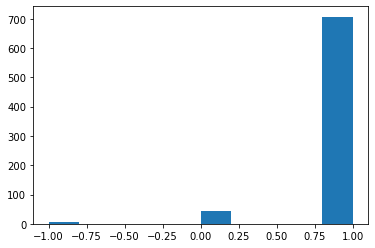

In [17]:
plt.hist(pred_labels)

In [18]:
print(confusion_matrix(test_labels, pred_labels))

[[  2  14 204]
 [  0  13 130]
 [  3  16 373]]
